Code source: [Reference](https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/)

Data source : [Tab-delimited Bilingual Sentence Pairs](http://www.manythings.org/anki/)

<h1>Import the Required Libraries</h1>

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

<h1> Load the Data </h1>

In [ ]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [ ]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
data = read_text("/content/drive/MyDrive/Machine_translation_proj/archive/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

Mounted at /content/drive/


In [ ]:
deu_eng = deu_eng[:50000,:]

using only 50000 of 150000 data 

<h1> Text Cleaning / Preprocessing</h1>

<ul>
    <li style="font-size:150%;">We will get rid of the punctuation marks and then convert all the text to lower case.</li>
</ul>

In [ ]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Im giving up smoking', 'Ich höre mit dem Rauchen auf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #256952 (minshirui) & #407184 (MUIRIEL)'],
       ['Im glad I was nearby', 'Ich bin froh dass ich in der Nähe war',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547219 (CK) & #3448316 (Pfirsichbaeumchen)'],
       ['Im glad Tom has gone', 'Ich bin froh dass Tom weg ist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547217 (CK) & #5299642 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [ ]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

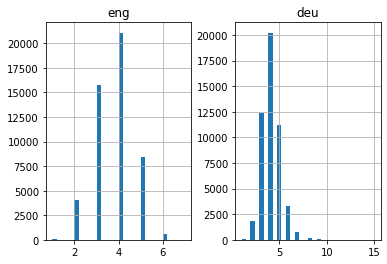

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

<ul>
    <li style="font-size:150%;">A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.</li>
    <li style="font-size:150%;">Now, vectorize our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.</li>
    <li style="font-size:150%;">Prepare tokenizers for both the German and English sentences</li>
</ul>

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6256


In [ ]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10329


<ul>
    <li style="font-size:150%;">We tokenized the data — i.e., converted the text to numerical values. This allows the neural network to perform operations on the input data.</li>
    <li style="font-size:150%;">When we run the tokenizer, it creates a word index, which is then used to convert each sentence to a vector.</li>

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [ ]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [ ]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

<h1> Define the Model</h1>

In [ ]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [ ]:
import tensorflow as tf
rms = tf.keras.optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


<ul>
    <li style="font-size:150%;">We are using the RMSprop optimizer in this model as it’s usually a good choice when working with recurrent neural networks.</li>
    <li style="font-size:150%;">Here I have used ‘sparse_categorical_crossentropy‘ as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory.</li>
               
</ul>

<h1> Fit the Model</h1>

<ul>
    <li style="font-size:150%;">ModelCheckpoint() function to save the model with the lowest validation loss. I personally prefer this method over early stopping.</li>
</ul>

In [ ]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 3.4089
Epoch 1: val_loss improved from inf to 3.00270, saving model to model.h1.24_jan_19


63/63 [==============================] - 288s 4s/step - loss: 3.4089 - val_loss: 3.0027
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.7667
Epoch 2: val_loss improved from 3.00270 to 2.76288, saving model to model.h1.24_jan_19


63/63 [==============================] - 277s 4s/step - loss: 2.7667 - val_loss: 2.7629
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.6017
Epoch 3: val_loss improved from 2.76288 to 2.54817, saving model to model.h1.24_jan_19


63/63 [==============================] - 279s 4s/step - loss: 2.6017 - val_loss: 2.5482
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 2.4145
Epoch 4: val_loss improved from 2.54817 to 2.42593, saving model to model.h1.24_jan_19


63/63 [==============================] - 277s 4s/step - loss: 2.4145 - val_loss: 2.4259
Epoch 5/30
63/63 [==============================] - ETA: 0s - loss: 2.2696
Epoch 5: val_loss improved from 2.42593 to 2.32808, saving model to model.h1.24_jan_19


63/63 [==============================] - 275s 4s/step - loss: 2.2696 - val_loss: 2.3281
Epoch 6/30
63/63 [==============================] - ETA: 0s - loss: 2.1424
Epoch 6: val_loss improved from 2.32808 to 2.21418, saving model to model.h1.24_jan_19


63/63 [==============================] - 275s 4s/step - loss: 2.1424 - val_loss: 2.2142
Epoch 7/30
63/63 [==============================] - ETA: 0s - loss: 2.0205
Epoch 7: val_loss improved from 2.21418 to 2.15477, saving model to model.h1.24_jan_19


63/63 [==============================] - 279s 4s/step - loss: 2.0205 - val_loss: 2.1548
Epoch 8/30
63/63 [==============================] - ETA: 0s - loss: 1.9061
Epoch 8: val_loss improved from 2.15477 to 2.04593, saving model to model.h1.24_jan_19


63/63 [==============================] - 277s 4s/step - loss: 1.9061 - val_loss: 2.0459
Epoch 9/30
63/63 [==============================] - ETA: 0s - loss: 1.7990
Epoch 9: val_loss improved from 2.04593 to 1.97396, saving model to model.h1.24_jan_19


63/63 [==============================] - 273s 4s/step - loss: 1.7990 - val_loss: 1.9740
Epoch 10/30
63/63 [==============================] - ETA: 0s - loss: 1.6928
Epoch 10: val_loss improved from 1.97396 to 1.89865, saving model to model.h1.24_jan_19


63/63 [==============================] - 273s 4s/step - loss: 1.6928 - val_loss: 1.8987
Epoch 11/30
63/63 [==============================] - ETA: 0s - loss: 1.5916
Epoch 11: val_loss improved from 1.89865 to 1.82198, saving model to model.h1.24_jan_19


63/63 [==============================] - 276s 4s/step - loss: 1.5916 - val_loss: 1.8220
Epoch 12/30
63/63 [==============================] - ETA: 0s - loss: 1.4958
Epoch 12: val_loss improved from 1.82198 to 1.77627, saving model to model.h1.24_jan_19


63/63 [==============================] - 272s 4s/step - loss: 1.4958 - val_loss: 1.7763
Epoch 13/30
63/63 [==============================] - ETA: 0s - loss: 1.4020
Epoch 13: val_loss improved from 1.77627 to 1.69273, saving model to model.h1.24_jan_19


63/63 [==============================] - 273s 4s/step - loss: 1.4020 - val_loss: 1.6927
Epoch 14/30
63/63 [==============================] - ETA: 0s - loss: 1.3145
Epoch 14: val_loss improved from 1.69273 to 1.64948, saving model to model.h1.24_jan_19


63/63 [==============================] - 273s 4s/step - loss: 1.3145 - val_loss: 1.6495
Epoch 15/30
63/63 [==============================] - ETA: 0s - loss: 1.2302
Epoch 15: val_loss improved from 1.64948 to 1.60789, saving model to model.h1.24_jan_19


63/63 [==============================] - 272s 4s/step - loss: 1.2302 - val_loss: 1.6079
Epoch 16/30
63/63 [==============================] - ETA: 0s - loss: 1.1494
Epoch 16: val_loss improved from 1.60789 to 1.57126, saving model to model.h1.24_jan_19


63/63 [==============================] - 276s 4s/step - loss: 1.1494 - val_loss: 1.5713
Epoch 17/30
63/63 [==============================] - ETA: 0s - loss: 1.0755
Epoch 17: val_loss improved from 1.57126 to 1.51873, saving model to model.h1.24_jan_19


63/63 [==============================] - 273s 4s/step - loss: 1.0755 - val_loss: 1.5187
Epoch 18/30
63/63 [==============================] - ETA: 0s - loss: 0.9999
Epoch 18: val_loss improved from 1.51873 to 1.51368, saving model to model.h1.24_jan_19


63/63 [==============================] - 272s 4s/step - loss: 0.9999 - val_loss: 1.5137
Epoch 19/30
63/63 [==============================] - ETA: 0s - loss: 0.9332
Epoch 19: val_loss improved from 1.51368 to 1.46078, saving model to model.h1.24_jan_19


63/63 [==============================] - 272s 4s/step - loss: 0.9332 - val_loss: 1.4608
Epoch 20/30
63/63 [==============================] - ETA: 0s - loss: 0.8674
Epoch 20: val_loss improved from 1.46078 to 1.43907, saving model to model.h1.24_jan_19


63/63 [==============================] - 273s 4s/step - loss: 0.8674 - val_loss: 1.4391
Epoch 21/30
63/63 [==============================] - ETA: 0s - loss: 0.8052
Epoch 21: val_loss improved from 1.43907 to 1.40904, saving model to model.h1.24_jan_19


63/63 [==============================] - 273s 4s/step - loss: 0.8052 - val_loss: 1.4090
Epoch 22/30
63/63 [==============================] - ETA: 0s - loss: 0.7469
Epoch 22: val_loss improved from 1.40904 to 1.40362, saving model to model.h1.24_jan_19


63/63 [==============================] - 272s 4s/step - loss: 0.7469 - val_loss: 1.4036
Epoch 23/30
63/63 [==============================] - ETA: 0s - loss: 0.6908
Epoch 23: val_loss improved from 1.40362 to 1.37648, saving model to model.h1.24_jan_19


63/63 [==============================] - 273s 4s/step - loss: 0.6908 - val_loss: 1.3765
Epoch 24/30
63/63 [==============================] - ETA: 0s - loss: 0.6385
Epoch 24: val_loss improved from 1.37648 to 1.34881, saving model to model.h1.24_jan_19


63/63 [==============================] - 271s 4s/step - loss: 0.6385 - val_loss: 1.3488
Epoch 25/30
63/63 [==============================] - ETA: 0s - loss: 0.5868
Epoch 25: val_loss improved from 1.34881 to 1.34657, saving model to model.h1.24_jan_19


63/63 [==============================] - 274s 4s/step - loss: 0.5868 - val_loss: 1.3466
Epoch 26/30
63/63 [==============================] - ETA: 0s - loss: 0.5406
Epoch 26: val_loss improved from 1.34657 to 1.33200, saving model to model.h1.24_jan_19


63/63 [==============================] - 272s 4s/step - loss: 0.5406 - val_loss: 1.3320
Epoch 27/30
63/63 [==============================] - ETA: 0s - loss: 0.4975
Epoch 27: val_loss improved from 1.33200 to 1.33001, saving model to model.h1.24_jan_19


63/63 [==============================] - 273s 4s/step - loss: 0.4975 - val_loss: 1.3300
Epoch 28/30
63/63 [==============================] - ETA: 0s - loss: 0.4568
Epoch 28: val_loss improved from 1.33001 to 1.32793, saving model to model.h1.24_jan_19


63/63 [==============================] - 272s 4s/step - loss: 0.4568 - val_loss: 1.3279
Epoch 29/30
63/63 [==============================] - ETA: 0s - loss: 0.4189
Epoch 29: val_loss improved from 1.32793 to 1.29926, saving model to model.h1.24_jan_19


63/63 [==============================] - 271s 4s/step - loss: 0.4189 - val_loss: 1.2993
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 0.3834
Epoch 30: val_loss did not improve from 1.29926
63/63 [==============================] - 256s 4s/step - loss: 0.3834 - val_loss: 1.3005


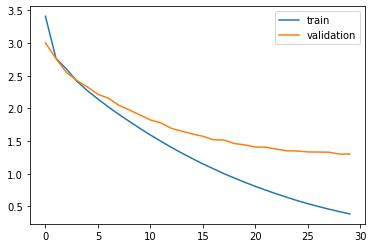

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

<h1> Prediction on unseen data</h1>

In [ ]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
# print 15 rows randomly
pred_df.head(15)

<center><h1> CONCLUSION</h1></center>
<br>

<ul>
    <li style="font-size:150%;">Our Seq2Seq model does a decent job. But there are several instances where it misses out on understanding the key words.</li>
    <li style="font-size:150%;">These are the challenges you will face on a regular basis in NLP. But these aren’t immovable obstacles. We can mitigate such challenges by using more training data and building a better (or more complex) model.</li>
</ul>